# EXPLORATION_03

## 1. 사진 준비하기

### 이미지 처리를 위해 opencv와 노트북에 이미지를 출력하기 위한 matplotlib 읽어오기

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

### 준비한 이미지 읽기

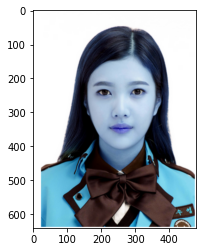

In [153]:
import os
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/증명사진.png'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr,(480,640))    # 480x640의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
img_wcopy = img_bgr.copy() # 스티커를 자연스럽게 붙이는 용도로 별도 보관(투명도)
plt.imshow(img_bgr)
plt.show()

### 색깔 보정처리

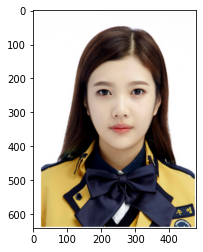

In [4]:
# plt.imshow 이전에 RGB 이미지로 바꾸는 것을 잊지마세요. 
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

## 2. 얼굴 검출 (face detection)

###  dlib을 활용해 hog detector 선언

In [5]:
import dlib
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언

### detector를 이용해서 얼굴의 bounding box를 추출

In [6]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)

### 찾은 얼굴을 화면에 출력하기

rectangles[[(142, 192) (365, 415)]]


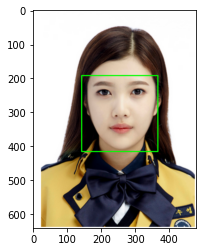

In [7]:
print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## 3. 얼굴 랜드마크 (face landmark)

### landmark 모델 불러오기

In [8]:
import os
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

In [9]:
# landmark_predictor 는 RGB 이미지와 dlib.rectangle을 입력 받아 
# dlib.full_object_detection 를 반환합니다.
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


### 랜드마크를 영상에 출력하기

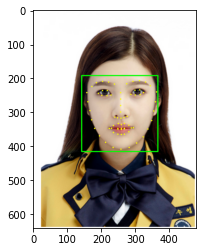

In [10]:
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## 4. 스티커 적용하기

### 좌표 확인하기

In [11]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[2]) # 왼
    print (landmark[30])  #오
    print (landmark[36]) # 위
    print (landmark[48])  # 아래
    
    x = landmark[2][0]
    y = landmark[36][1]
    w = (landmark[30][0] - x)*2
    h = landmark[48][1]-y
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(166, 295)
(256, 299)
(191, 244)
(223, 347)
(x,y) : (166,244)
(w,h) : (180,103)


#### => (x,y)를 스티커의 시작점 top-left로 지정하였다.
<br>
<div>
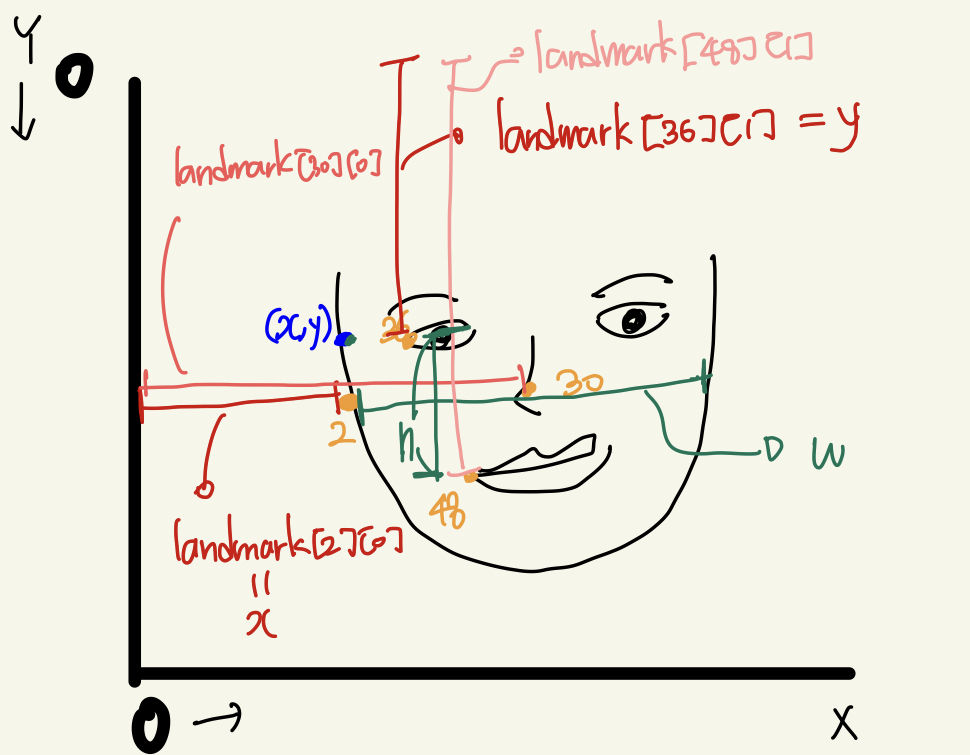
</div>

### 준비해 둔 스티커 이미지를 읽어서 적용해보기

(103, 180, 3)


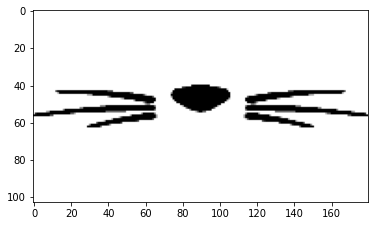

In [12]:
import os
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)
plt.imshow(img_sticker)

### x, y 좌표 조정하기 => 처음부터 top-left 좌표로 시작점을 잡았기 때문에 생략!

In [13]:
#refined_x = x-w//4  # left
#refined_y = y + h//20   # top
#print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

### 원본 이미지의 범위를 벗어난 스티커 부분 제거 => 벗어난 부분이 없으므로 생략!

In [14]:
#img_sticker = img_sticker[-refined_y:]
#print (img_sticker.shape)

#top의 y를 원본 이미지의 경계 값으로 수정
#refined_y = 0
#print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

### 원본 이미지에 스티커를 적용

In [15]:
sticker_area = img_show[y:y+img_sticker.shape[0], x:x+img_sticker.shape[1]]
img_show[y:y+img_sticker.shape[0], x:x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

#### => img_show[좌측 상단 y 좌표 : 우측 하단 y 좌표, 좌측 상단 x 좌표 : 우측 하단 x 좌표]
<br>
<div>
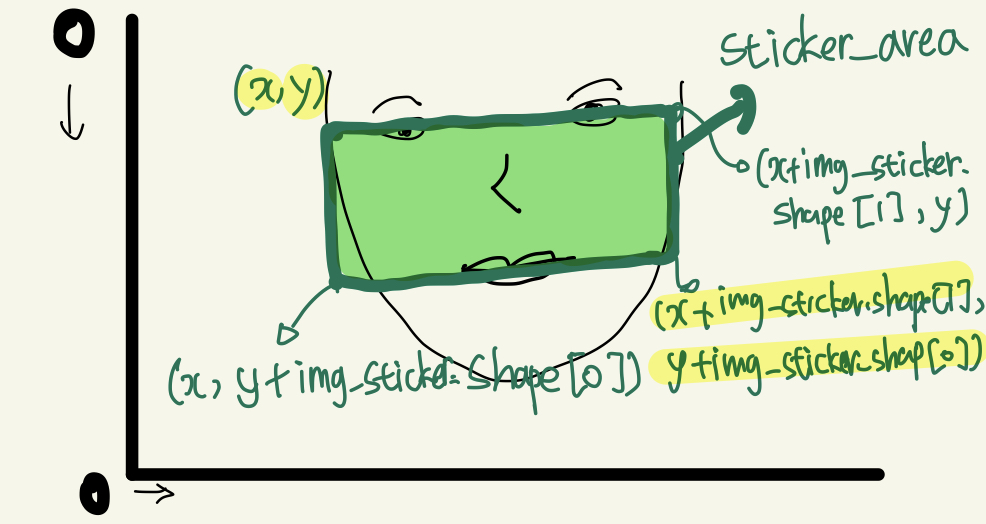
</div>

### 결과 이미지 출력

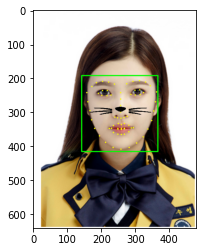

(640, 480, 3)

In [16]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()
img_show.shape


### bounding box와 landmark를 제거하고 최종 결과 출력

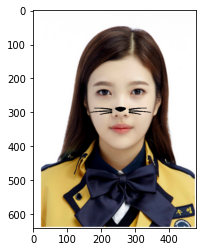

In [17]:
sticker_area = img_bgr[y:y+img_sticker.shape[0], x:x+img_sticker.shape[1]]
img_bgr[y:y+img_sticker.shape[0], x:x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)


plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

### 스티커를 자연스럽게 하기

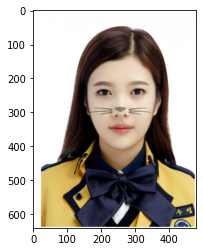

In [18]:
sticker_area = img_wcopy[y:y+img_sticker.shape[0], x:x+img_sticker.shape[1]]
img_wcopy[y:y+img_sticker.shape[0], x:x+img_sticker.shape[1]] = \
    cv2.addWeighted(sticker_area, 0.6,np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8), 0.4, 0)

img_w_rgb=cv2.cvtColor(img_wcopy, cv2.COLOR_BGR2RGB)
plt.imshow(img_w_rgb)
plt.show()  


**************************************

# 🛠 이미지 변형하기

# 1. 회전

In [19]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

## (1) 180도 회전

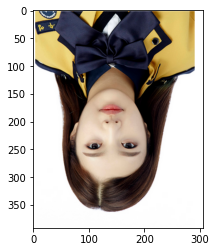

In [20]:
import os
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/증명사진.png'
image = cv2.imread(my_image_path)
image = cv2.resize(image,dsize=(306 ,392))    # Resize
img180 = cv2.rotate(image, cv2.ROTATE_180)
img_show180 = img180.copy()

img_rgb180 = cv2.cvtColor(img180, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb180)
plt.show()

#### 얼굴 검출

rectangles[[(15, 118) (201, 304)]]


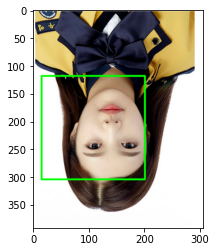

In [21]:
import dlib
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언

img_rgb180 = cv2.cvtColor(img180, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb180, 1)   #- (image, num of img pyramid)

print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show180, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb180 =  cv2.cvtColor(img_show180, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb180)
plt.show()

#### 얼굴 랜드마크

68


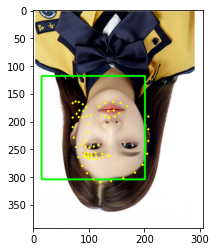

In [22]:
import os
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

# landmark_predictor 는 RGB 이미지와 dlib.rectangle을 입력 받아 
# dlib.full_object_detection 를 반환합니다.
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb180, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show180, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb180 = cv2.cvtColor(img_show180, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb180)
plt.show()

#### 스티커적용

(73, 229)
(93, 235)
(78, 186)
(91, 262)
(x,y) : (73,186)
(w,h) : (40,76)
(76, 40, 3)


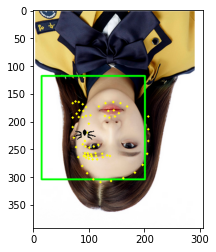

In [23]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[2]) # 왼
    print (landmark[30])  #오
    print (landmark[36]) # 위
    print (landmark[48])  # 아래
    
    x = landmark[2][0]
    y = landmark[36][1]
    w = (landmark[30][0] - x)*2
    h = landmark[48][1]-y
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))
    

import os
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)
plt.imshow(img_sticker)

sticker_area = img_show180[y:y+img_sticker.shape[0], x:x+img_sticker.shape[1]]
img_show180[y:y+img_sticker.shape[0], x:x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_show180, cv2.COLOR_BGR2RGB))
plt.show()

### ✔ 180도 회전시켰을 때, 찍힌 랜드마크를 보니 얼굴인식이 제대로 되지 않는 걸 알 수 있다. 사진은 눈코입이 뒤집어져 있지만 , 랜드마크는 뒤집어진 눈코입을 제대로 인식하지 못한다.

***

## (2) 90도 회전

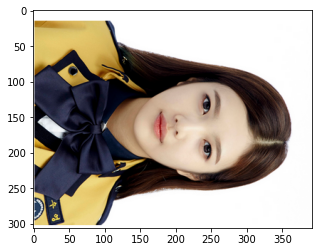

In [24]:
img90 = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
img_show90 = img90.copy()

img_rgb90 = cv2.cvtColor(img90, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb90)
plt.show()


#### 얼굴검출

rectangles[]


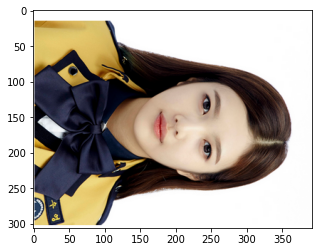

In [25]:
import dlib
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언

img_rgb90 = cv2.cvtColor(img90, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb90, 1)   #- (image, num of img pyramid)

print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show90, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb90 =  cv2.cvtColor(img_show90, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb90)
plt.show()

### ✔초록색 상자가 나타나지 않은 것을 보아 얼굴 검출이 되지 않았다. 90도 회전시켰을 때, 얼굴인식이 안 되었다.

***

## (3) 얼굴이 약간 기울어진 사진

#### 사진 준비하기

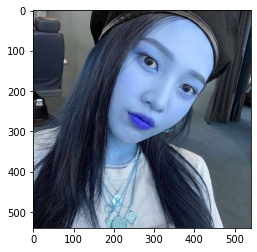

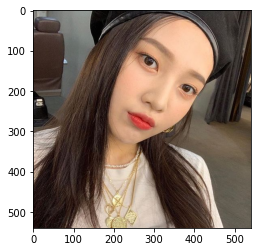

In [131]:
import os
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/조이23.jpg'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (540, 540))    #  Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
img_rot = img_bgr.copy() # 회전을 위한 이미지 별도 보관
plt.imshow(img_bgr)
plt.show()

# plt.imshow 이전에 RGB 이미지로 바꾸는 것을 잊지마세요. 
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()


#### 얼굴 검출

rectangles[[(171, 82) (438, 350)]]


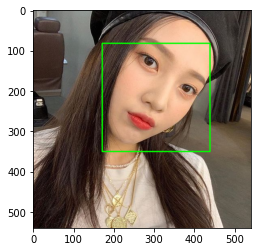

In [132]:
import dlib
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)

print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

#### 얼굴 랜드마크

68


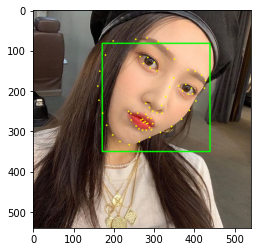

In [133]:
import os
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

# landmark_predictor 는 RGB 이미지와 dlib.rectangle을 입력 받아 
# dlib.full_object_detection 를 반환합니다.
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

#### 스티커 적용하기

(165, 151)
(318, 236)
(265, 115)
(236, 251)
(x,y) : (165,115)
(w,h) : (306,136)
(136, 306, 3)


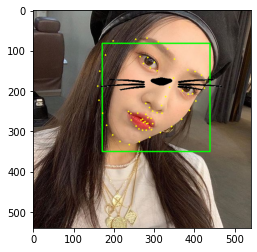

In [134]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[2]) # 왼
    print (landmark[30])  #오
    print (landmark[36]) # 위
    print (landmark[48])  # 아래
    
    x = landmark[2][0]
    y = landmark[36][1]
    w = (landmark[30][0] - x)*2
    h = landmark[48][1]-y
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))
    

import os
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)
plt.imshow(img_sticker)

sticker_area = img_show[y:y+img_sticker.shape[0], x:x+img_sticker.shape[1]]
img_show[y:y+img_sticker.shape[0], x:x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

#### 최종결과 출력

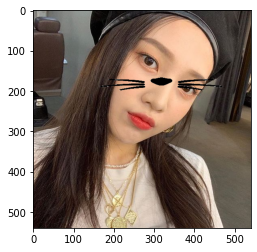

In [135]:
sticker_area = img_bgr[y:y+img_sticker.shape[0], x:x+img_sticker.shape[1]]
img_bgr[y:y+img_sticker.shape[0], x:x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

### ✔ 얼굴 검출과 랜드마크표시는 잘 된다. 대신, 스티커가 제대로 붙여지지 않았다. 얼굴 각도가 변함에 따라 스티커도 맞춰서 회전시켜줘야 될 것 같다.

## 💡  cv2.getRotationMatrix2D(center, angle, scale) -> retval 
### - center: 회전 중심 좌표. (x, y) 튜플
### - angle: (반시계 방향) 회전 각도(degree). 음수는 시계 방향.
### - scale: 추가적인 확대 비율
### - retval: 2x3 어파인 변환 행렬. 실수형.



(265, 115)
(395, 207)
(318, 236)
(348, 168)
(284, 266)
(x,y) : (318,236)
(w,h) : (306,136)


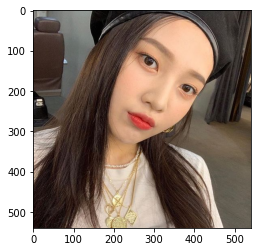

In [136]:
import math

for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # 코
    print (landmark[2])  #왼쪽 
    print(landmark[27]) # 양쪽 눈 가운데
  
  
    x=landmark[30][0]
    y=landmark[30][1]
    w = (x-landmark[2][0])*2
    h=(y-landmark[27][1])*2
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

plt.imshow(cv2.cvtColor(img_rot, cv2.COLOR_BGR2RGB))
plt.show()

(136, 306, 3)


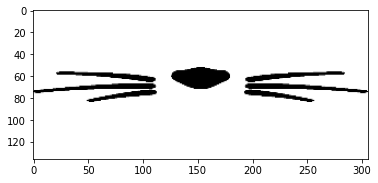

In [137]:

import os
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker_r = cv2.imread(sticker_path)
img_sticker_r = cv2.resize(img_sticker_r, (w,h))
print (img_sticker_r.shape)
plt.imshow(img_sticker_r)



In [138]:
# x,y 좌표 조정하기 (top-left)
refined_x = x-w//2  # left
refined_y = y-h//2   # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (165,168)


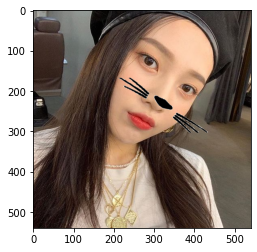

In [139]:
h_w = (landmark[45][1]-landmark[36][1])/(landmark[45][0]-landmark[36][0])
m = cv2.getRotationMatrix2D((w//2,h//2), -math.atan(h_w)/math.pi*180, 1)
img_sticker_r=cv2.warpAffine(img_sticker_r,m,(w,h),borderValue=(255,255,255))

sticker_area = img_rot[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_rot[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker_r==255,sticker_area,img_sticker_r).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_rot, cv2.COLOR_BGR2RGB))
plt.show()

### => 두 눈의 양끝 좌표를 이용하여 기울기를 구하였다.
<br>
<div>
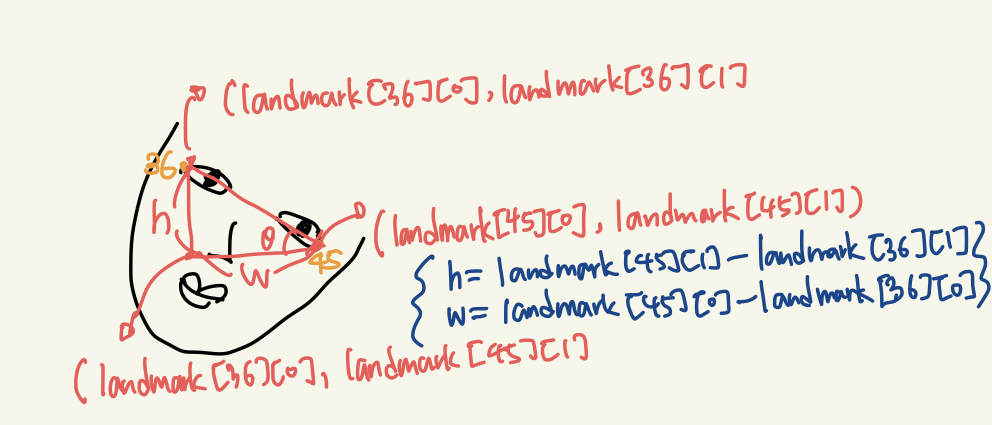
</div>


* 그림에서는 편의상 h,w로 놓고 계산하였다. arc tangent를 이용하여 눈의 기울기를 구하였다.
* h_w = (landmark[45][1]-landmark[36][1])/(landmark[45][0]-landmark[36][0]) -> 이 코드가 위의 그림에서의 h/w를 나타낸 것이다. 
* arc tan(h_w)/math.pi*180 이 식의 결과가  눈의 기울어짐(각도)이다.


<br>
<div>
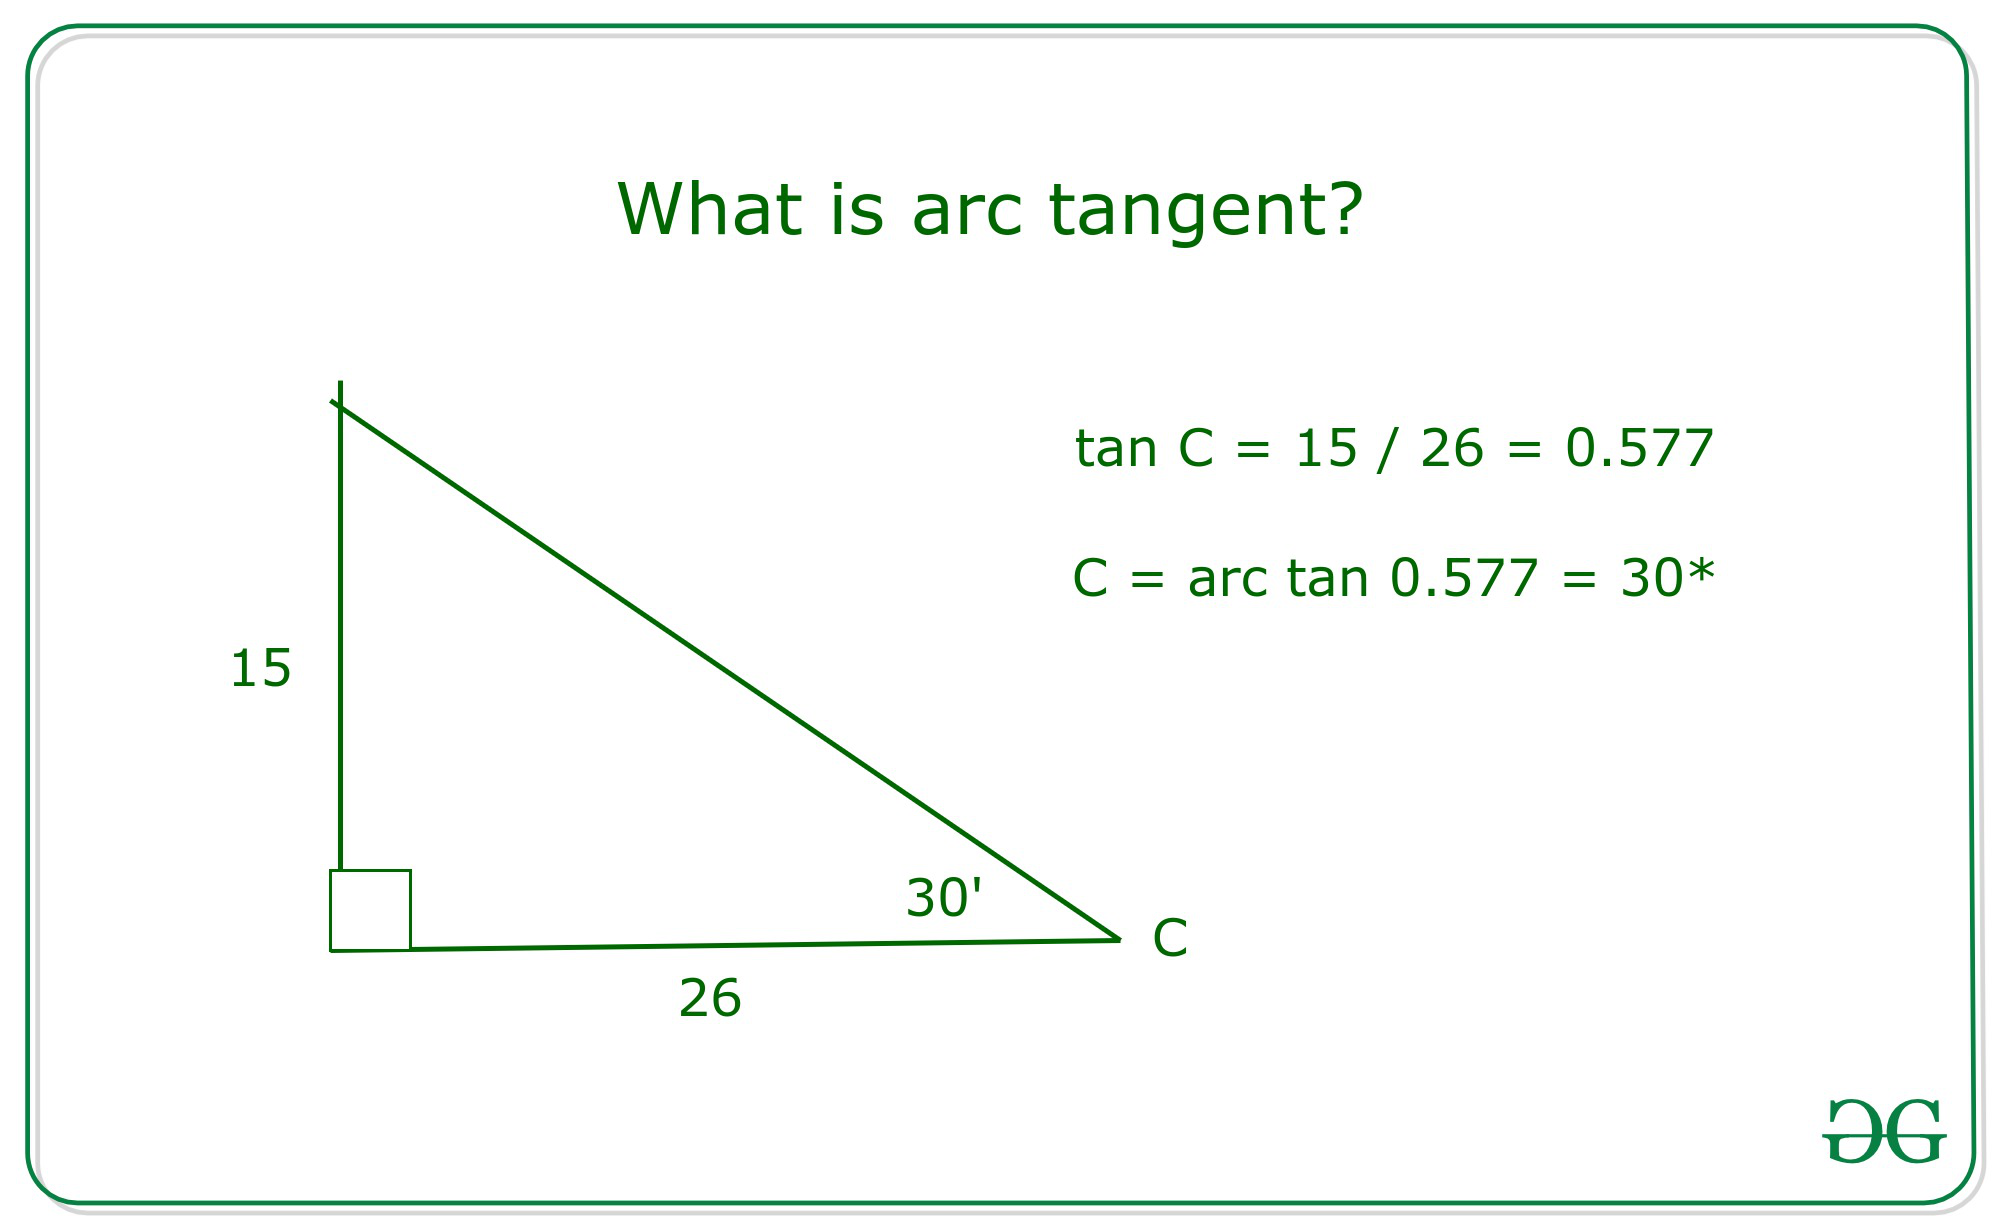
</div>

## 다른 사진에도 똑같은 코드가 적용될까❓

* 다른 사진에 적용시켜보니 에러가 뜬다. 아마 위의 코드는 저 사진에만 적용되는 코드인거 같다. 사진마다 일일이 코드를 바꾸지말고 모든 사진에 적용되는 코드는 없을까..? 

***

# 2. 밝기에 따라

## (1) 밝은 사진

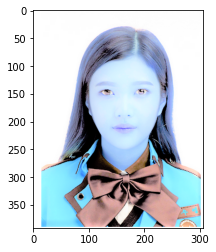

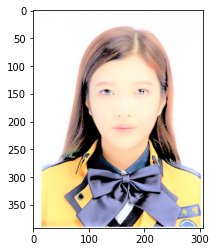

In [153]:
import os
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/bright.png'
img_bright = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
img_bright = cv2.resize(img_bright,(306 ,392))    #  Resize
img_show_br = img_bright.copy()      #- 출력용 이미지 별도 보관
plt.imshow(img_bright)
plt.show()

# plt.imshow 이전에 RGB 이미지로 바꾸는 것을 잊지마세요. 
img_rgb_br = cv2.cvtColor(img_bright, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb_br)
plt.show()

#### 얼굴 검출

rectangles[[(96, 110) (225, 239)]]


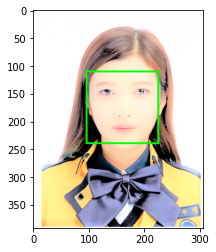

In [154]:
import dlib
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언

img_rgb_br = cv2.cvtColor(img_bright, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb_br, 1)   #- (image, num of img pyramid)

print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show_br, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb_br =  cv2.cvtColor(img_show_br, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb_br)
plt.show()

#### 얼굴 랜드마크

68


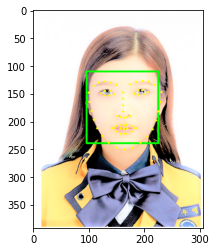

In [155]:
import os
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

# landmark_predictor 는 RGB 이미지와 dlib.rectangle을 입력 받아 
# dlib.full_object_detection 를 반환합니다.
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb_br, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show_br, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb_br = cv2.cvtColor(img_show_br, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb_br)
plt.show()

#### 스티커 적용

(105, 181)
(162, 182)
(122, 149)
(142, 212)
(x,y) : (105,149)
(w,h) : (114,63)
(63, 114, 3)


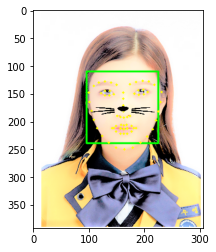

In [156]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[2]) # 왼
    print (landmark[30])  #오
    print (landmark[36]) # 위
    print (landmark[48])  # 아래
    
    x = landmark[2][0]
    y = landmark[36][1]
    w = (landmark[30][0] - x)*2
    h = landmark[48][1]-y
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))
    

import os
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)
plt.imshow(img_sticker)

sticker_area = img_show_br[y:y+img_sticker.shape[0], x:x+img_sticker.shape[1]]
img_show_br[y:y+img_sticker.shape[0], x:x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_show_br, cv2.COLOR_BGR2RGB))
plt.show()

### 사진이 밝아져도 이목구비가 구분이 되면 얼굴인식이 잘 되기 때문에 스티커를 원하는 위치에 적용할 수 있다.

### => 이목구비가 구분이 안 될 정도로 밝은 사진이라면 ❓  

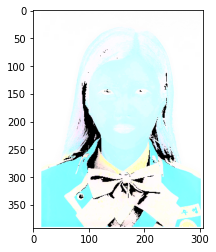

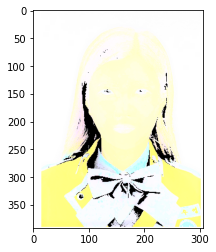

rectangles[[(96, 110) (225, 239)]]


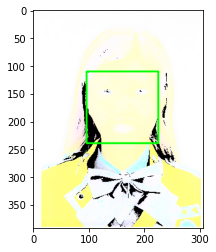

68


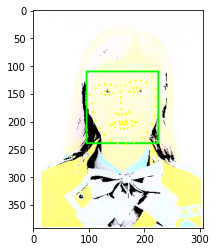

(107, 183)
(158, 178)
(123, 150)
(140, 206)
(x,y) : (107,150)
(w,h) : (102,56)
(56, 102, 3)


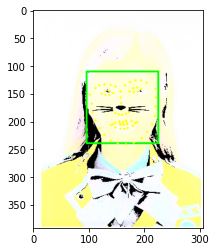

In [157]:
import os
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/toomuchbright.png'
img_bright = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
img_bright = cv2.resize(img_bright,(306 ,392))    # Resize
img_show_br = img_bright.copy()      #- 출력용 이미지 별도 보관
plt.imshow(img_bright)
plt.show()

# plt.imshow 이전에 RGB 이미지로 바꾸는 것을 잊지마세요. 
img_rgb_br = cv2.cvtColor(img_bright, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb_br)
plt.show()

# 얼굴 검출
import dlib
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언

img_rgb_br = cv2.cvtColor(img_bright, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb_br, 1)   #- (image, num of img pyramid)

print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show_br, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb_br =  cv2.cvtColor(img_show_br, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb_br)
plt.show()
 
# 얼굴 랜드마크
import os
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

# landmark_predictor 는 RGB 이미지와 dlib.rectangle을 입력 받아 
# dlib.full_object_detection 를 반환합니다.
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb_br, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show_br, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb_br = cv2.cvtColor(img_show_br, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb_br)
plt.show()

# 스티커 적용
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[2]) # 왼
    print (landmark[30])  #오
    print (landmark[36]) # 위
    print (landmark[48])  # 아래
    
    x = landmark[2][0]
    y = landmark[36][1]
    w = (landmark[30][0] - x)*2
    h = landmark[48][1]-y
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))
    

import os
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)
plt.imshow(img_sticker)

sticker_area = img_show_br[y:y+img_sticker.shape[0], x:x+img_sticker.shape[1]]
img_show_br[y:y+img_sticker.shape[0], x:x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_show_br, cv2.COLOR_BGR2RGB))
plt.show()

### ✔ 이목구비 형태가 대충 보이긴 보이므로 얼굴 인식이 된다. 하지만 랜드마크가 찍힌 것을 확대해서 보면, 눈과 입 위치에 랜드마크를 정확히 찍지 못하였다. 아마 이목구비 형태가 보이지 않을 정도의 밝기 사진이라면 얼굴 인식에 어려움이 있을 것으로 예상된다.
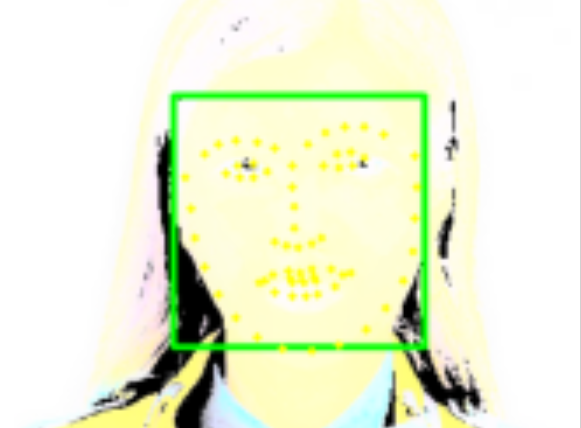

***

## (2) 어두운 사진 

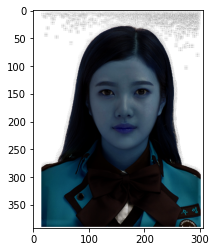

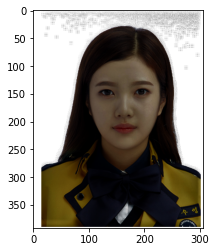

In [159]:
import os
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/dark.png'
img_dark = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
img_bright = cv2.resize(img_dark,(306 ,392))    #  Resize
img_show_da = img_dark.copy()      #- 출력용 이미지 별도 보관
plt.imshow(img_dark)
plt.show()

# plt.imshow 이전에 RGB 이미지로 바꾸는 것을 잊지마세요. 
img_rgb_da = cv2.cvtColor(img_dark, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb_da)
plt.show()

#### 얼굴 검출

rectangles[[(96, 110) (225, 239)]]


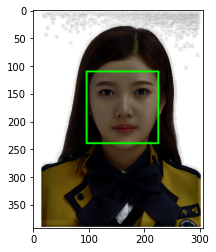

In [160]:
import dlib
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언

img_rgb_da = cv2.cvtColor(img_dark, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb_da, 1)   #- (image, num of img pyramid)

print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show_da, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb_da =  cv2.cvtColor(img_show_da, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb_da)
plt.show()

#### 얼굴 랜드마크

68


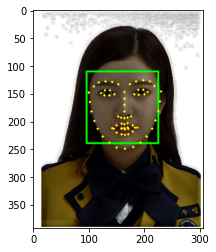

In [161]:
import os
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

# landmark_predictor 는 RGB 이미지와 dlib.rectangle을 입력 받아 
# dlib.full_object_detection 를 반환합니다.
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb_da, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show_da, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb_da = cv2.cvtColor(img_show_da, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb_da)
plt.show()

#### 스티커 적용

(105, 182)
(164, 182)
(122, 149)
(142, 212)
(x,y) : (105,149)
(w,h) : (118,63)
(63, 118, 3)


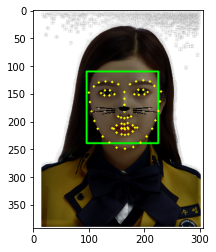

In [162]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[2]) # 왼
    print (landmark[30])  #오
    print (landmark[36]) # 위
    print (landmark[48])  # 아래
    
    x = landmark[2][0]
    y = landmark[36][1]
    w = (landmark[30][0] - x)*2
    h = landmark[48][1]-y
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))
    

import os
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)
plt.imshow(img_sticker)

sticker_area = img_show_da[y:y+img_sticker.shape[0], x:x+img_sticker.shape[1]]
img_show_da[y:y+img_sticker.shape[0], x:x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_show_da, cv2.COLOR_BGR2RGB))
plt.show()

###  밝은 사진과 마찬가지로 이목구비 형태가 보이면 얼굴이 인식이 잘된다! 아마 이목구비가 구분되지 않을 정도의 어두운 사진을 가져오면 얼굴인식이 잘 안 될 것이다. 

***

# 3. 촬영거리에 따라

## 멀리 있는 사진1

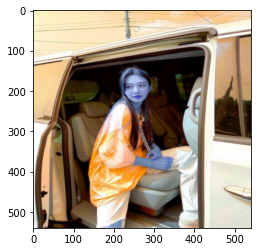

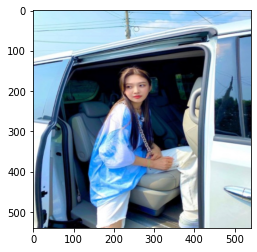

In [163]:
import os
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/조이17.jpg'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (540, 540))    # Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
plt.imshow(img_bgr)
plt.show()

# plt.imshow 이전에 RGB 이미지로 바꾸는 것을 잊지마세요. 
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()


#### 얼굴 검출

rectangles[[(225, 170) (287, 232)]]


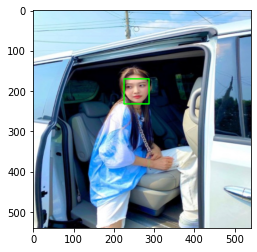

In [164]:
import dlib
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)

print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

#### 얼굴 랜드마크

68


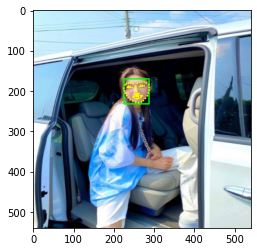

In [165]:
import os
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

# landmark_predictor 는 RGB 이미지와 dlib.rectangle을 입력 받아 
# dlib.full_object_detection 를 반환합니다.
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

#### 스티커 적용하기

(228, 206)
(256, 203)
(233, 191)
(247, 215)
(x,y) : (228,191)
(w,h) : (56,24)
(24, 56, 3)


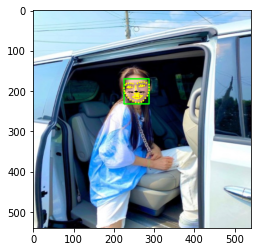

In [166]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[2]) # 왼
    print (landmark[30])  #오
    print (landmark[36]) # 위
    print (landmark[48])  # 아래
    
    x = landmark[2][0]
    y = landmark[36][1]
    w = (landmark[30][0] - x)*2
    h = landmark[48][1]-y
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))
    

import os
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)
plt.imshow(img_sticker)

sticker_area = img_show[y:y+img_sticker.shape[0], x:x+img_sticker.shape[1]]
img_show[y:y+img_sticker.shape[0], x:x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

#### 최종결과 출력

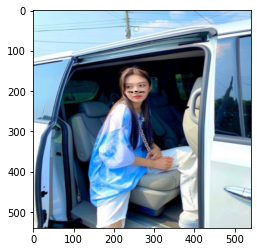

In [167]:
sticker_area = img_bgr[y:y+img_sticker.shape[0], x:x+img_sticker.shape[1]]
img_bgr[y:y+img_sticker.shape[0], x:x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

### 촬영거리가 멀어져도 인식이 잘 된다. 더 멀어지면 어떻게 될까❓

## 멀리 있는 사진2

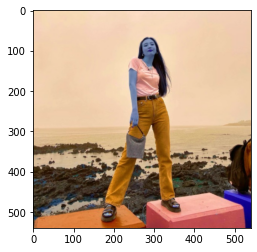

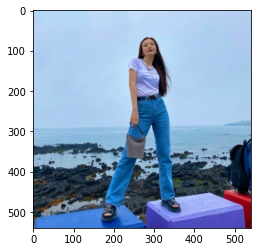

In [168]:
import os
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/조이18.jpg'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (540, 540))    # 640x360의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
plt.imshow(img_bgr)
plt.show()

# plt.imshow 이전에 RGB 이미지로 바꾸는 것을 잊지마세요. 
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

#### 얼굴 검출 & 랜드마크

rectangles[[(269, 74) (305, 110)]]
68


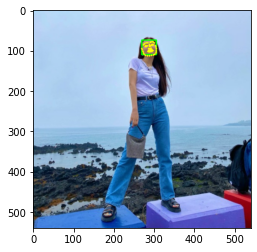

In [169]:
# 얼굴 검출
import dlib
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)

print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

# 랜드마크
import os
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

# landmark_predictor 는 RGB 이미지와 dlib.rectangle을 입력 받아 
# dlib.full_object_detection 를 반환합니다.
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

#### 스티커 적용 & 최종 결과 출력

(272, 102)
(289, 90)
(277, 90)
(284, 102)
(x,y) : (272,90)
(w,h) : (34,12)
(12, 34, 3)


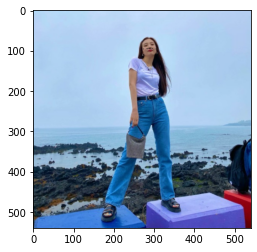

In [170]:
# 스티커 적용
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[2]) # 왼
    print (landmark[30])  #오
    print (landmark[36]) # 위
    print (landmark[48])  # 아래
    
    x = landmark[2][0]
    y = landmark[36][1]
    w = (landmark[30][0] - x)*2
    h = landmark[48][1]-y
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))
    

import os
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)
plt.imshow(img_sticker)

sticker_area = img_show[y:y+img_sticker.shape[0], x:x+img_sticker.shape[1]]
img_show[y:y+img_sticker.shape[0], x:x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)


# 최종 결과 출력
sticker_area = img_bgr[y:y+img_sticker.shape[0], x:x+img_sticker.shape[1]]
img_bgr[y:y+img_sticker.shape[0], x:x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

### 더 멀리 떨어진 촬영거리에서도 얼굴 인식이 잘 되어 스티커를 원하는 위치에 적용할 수 있었다.

***

## 회고

### 막혔던 부분

### 1. x,y 좌표와 w,h 정하기
* 처음에 노드 예시만 보고 따라하다가 좌표를 어떻게 설정하는지 모르겠어서 스티커가 계속 이마에 붙어있었다. 그래서 그림(맨 위쪽에 첨부한 그림)을 그리면서 좌표위치를 계산해보니 이해가 잘 되었다. 

### 2. 스티커 적용시, 스티커의 흰배경이 그대로 보였다

sticker_area = img_show[y:y+img_sticker.shape[0], x:x+img_sticker.shape[1]]
<br>img_show[y:y+img_sticker.shape[0], x:x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
    
* 원래 노드에 있는 예시에서는 np.where(img_sticker=0,~) 이었다. 이 코드를 그대로 적용하였더니 스티커의 흰배경이 그대로 적용되는 문제가 생겼다. 그래서 노드예시에서 img_sticker(왕관)를 출력해보니 [0,0,0,0 ,,,,,0,0,0] 이런 형태였고, 이 프로젝트의 img_sticker(고양이 수염)을 출력해보니 [255,255,255,,,,,,255,255] 이런 형태였다. 내 생각으로는..255가 흰색을 의미하고 그래서 스티커에서 255인 부분은 sticker_area를 쓰고, 255가 아닌 고양이수염 부분은 img_stricker를 사용한게 아닐까.. 라고 해석을 하면서 위의 코드처럼 img_stricker ==255로 코드를 작성하였다.

### 3. 스티커 자연스럽게 하기
* cv2.addWeighted 함수를 사용하여 스티커 뒤에 원본사진도 보이게 만드는 과정
* 처음에 계속 함수를 적용해도 스티커가 흐려지지 않았다. => 그 이유는?
* 그 전 과정이 최종결과 출력하는 과정이었는데 이 때, img_br를 사용하였다. 그래서 img_br에는 기존 스티커가 붙여있는 상태! 이것을 인지하지 못하고 img_br에 다시 cv.addWeighted 함수를 써서 흐려진 스티커를 적용했기 때문에 기존 스티커와 중첩이 됐던 것!
* 해결 방법 : 초반에 원본 사진을 불러올 때, img_wcopy = img_bgr.copy() 이렇게 따로 복사를 하여 저장하였다. 그리고 img_wcopy에 cv2.addWeighted를 적용하였다.

## 4. 스티커 회전하기
* cv2.getRotationMatrix2D 함수를 사용하여 스티커를 회전하기
* 좌표를 어떻게 설정해야되나.. 어려웠다.
* np.where 안에 sticker_area와 img_sticker의 shape이 같이야되는데 계속 다른 shape이라면서 에러가 떴었다.
* 다른 사진에도 적용되는 코드를 만들어 보고싶다. 내가 작성한 코드는 내가 선택한 사진에만 적용이 되는것 같다. 좌표를 어떻게 설정하고, 각도와 w,h는 또 어떻게 설정해야지 모든 사진에 적용을 될까....?

### 다양한 변수에 따라

#### - 얼굴 각도에 따라 스티커가 어떻게 변해야할까?
    : 얼굴 각도에 따라 스티커도 같이 기울기가 달라져야 한다. 그래서 자연스럽게 스티커를 적용할 수 가 있다. 
#### - 멀리서 촬영/ 옆으로 누워서 촬영시
    : 멀리서 촬영해도 이목구비가 잘 보이면 인식이 잘 되는 것 같다. 옆으로 누워서 촬영하면 왜 인식이 안 되는지에 대한 이유는 찾지못하였다. 대신 위에서 90도로 회전한 사진예시를 보면 옆으로 돌아간 얼굴은 인식되지 않는다는 것을 알 수 있었다.
#### - 실행 속도가 중요할까?
    : 중요하다! 실제로 사용되고 있는 사진 어플(스노우나 유라이크)를 사용해보면 스티커가 바로바로 적용되는 것을 볼 수 있다. 얼굴을 인식하자마자 스티커를 적용할 수 있어야 성능이 좋은 것이라고 생각한다.
#### - 스티커앱을 만들 때 정확도가 얼마나 중요할까?
    : 정확도가 높을수록 좋다고 생각한다. 얼굴인식을 하여 정확한 위치에 스티커를 적용해야되기 때문이다. 고양이 수염 스티커가 이마에 붙여지면 안되는 것처럼...